# Clustering Validation and Stability
    Measuring Quality, Robustness, and Trust in Unsupervised Models
## Objective

This notebook provides a systematic framework for validating and stress-testing clustering results, covering:

- Internal validation metrics

- Cluster separation and compactness

- Stability under resampling

- Sensitivity to preprocessing choices

- Business-oriented validation

It answers:

    How do we know if our clusters are meaningful, stable, and trustworthy?

## Why Clustering Validation Is Hard

Clustering is unsupervised:

- No ground truth labels

- Metrics are indirect proxies

- Multiple solutions may be valid

Therefore:
- ✔ Validation ≠ accuracy

- ✔ Stability and interpretability matter more than scores

## Dataset and Context

We continue using the synthetic finance customer dataset for consistency:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Unsupervised/synthetic_bank_customer_segmentation.csv")

df.head()

,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
0,56,106477.0,5268.0,0.06,3.1,1,24.1
1,69,109688.0,2206.0,0.00,2.0,1,22.0
2,46,94629.0,2998.0,0.22,3.2,1,36.1
3,32,49359.0,1725.0,0.17,4.6,1,24.4
4,60,91565.0,1807.0,0.06,21.3,7,17.3


### Dataset Features


| Feature            | Description           |
| ------------------ | --------------------- |
| age                | Customer age          |
| annual_income      | Annual income         |
| avg_monthly_spend  | Monthly spending      |
| credit_utilization | Credit usage ratio    |
| tenure_years       | Relationship duration |
| num_products       | Products owned        |
| risk_score         | Internal risk metric  |


### Feature Selection

DBSCAN is distance-based and requires numerical features.

#### Feature Matrix

In [2]:
features = [
    "age",
    "annual_income",
    "avg_monthly_spend",
    "credit_utilization",
    "tenure_years",
    "num_products",
    "risk_score"
]

X = df[features]


### Scaling (Non-Negotiable)


#### Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Internal Validation Metrics


| Metric            | Interpretation        |
| ----------------- | --------------------- |
| Silhouette        | Separation & cohesion |
| Davies–Bouldin    | Cluster overlap       |
| Calinski–Harabasz | Variance ratio        |


## K-Means Validation (Example)
### Fit K-Means

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)


### Metrics

In [5]:
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

print("Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels_kmeans))


Silhouette: 0.2187145125467434
Davies-Bouldin: 1.3682619869473363
Calinski-Harabasz: 1782.4570851719925


### Interpreting Scores (Rules of Thumb)

- Silhouette:

    - < 0.25 → weak structure

    - 0.25–0.5 → reasonable

    - 0.5 → strong separation
    
    

- Davies–Bouldin:

    - Lower is better
    
    

- Calinski–Harabasz:

    - Higher is better (relative)
    
    

## – Validation Across K Values
### Metric Curves

In [6]:
k_range = range(2, 9)

silhouette_scores = []
db_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))


### Plot

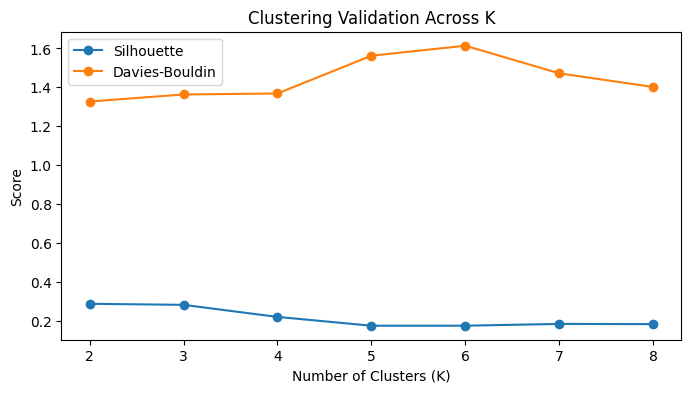

In [7]:
plt.figure(figsize=(8, 4))

plt.plot(k_range, silhouette_scores, marker="o", label="Silhouette")
plt.plot(k_range, db_scores, marker="o", label="Davies-Bouldin")

plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("Clustering Validation Across K")
plt.legend()
plt.show()


✔ Look for **stable regions**, not single peaks

## Validation for DBSCAN

DBSCAN does not require K but still needs evaluation.

### DBSCAN Example

In [8]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=5)
labels_db = dbscan.fit_predict(X_scaled)


### Silhouette (Excluding Noise)

In [9]:
mask = labels_db != -1

silhouette_db = silhouette_score(
    X_scaled[mask],
    labels_db[mask]
)

silhouette_db


np.float64(-0.3067279602578626)

### Cluster Stability (Resampling Test)

Stability = **clusters persist under perturbation**


#### Bootstrap Stability (K-Means)

In [10]:
from sklearn.metrics import adjusted_rand_score

rng = np.random.RandomState(42)
base_labels = labels_kmeans

stability_scores = []

for i in range(20):
    sample_idx = rng.choice(len(X_scaled), size=int(0.8 * len(X_scaled)), replace=False)
    X_sample = X_scaled[sample_idx]

    km = KMeans(n_clusters=4, random_state=i)
    sample_labels = km.fit_predict(X_sample)

    stability_scores.append(
        adjusted_rand_score(
            base_labels[sample_idx],
            sample_labels
        )
    )


### Stability Summary
np.mean(stability_scores), np.s

In [12]:
np.mean(stability_scores), np.std(stability_scores)


(np.float64(0.9634111936496623), np.float64(0.020441696340359684))

✔ Higher mean → more stable
✔ Low variance → robust

## Sensitivity to Preprocessing

Clustering results depend heavily on:

- Scaling choice

- Feature inclusion

- Outlier treatment

### Example — Robust Scaling

In [13]:
from sklearn.preprocessing import RobustScaler

X_robust = RobustScaler().fit_transform(X)
labels_robust = KMeans(n_clusters=4, random_state=42).fit_predict(X_robust)

silhouette_score(X_robust, labels_robust)


np.float64(0.21245454359246127)

    Compare against StandardScaler results.

##  Business Validation (Most Important)

Ask:

- Are clusters interpretable?

- Are sizes operationally viable?

- Do clusters align with known behaviors?

- Are decisions stable over time?

### Example: Cluster Profiles

In [14]:
df["cluster"] = labels_kmeans

profile = (
    df
    .groupby("cluster")[features]
    .mean()
    .round(2)
)

profile


,age,annual_income,avg_monthly_spend,credit_utilization,tenure_years,num_products,risk_score
cluster,,,,,,,
0,37.80,74939.52,2330.27,0.14,3.25,1.67,26.43
1,51.58,92488.89,3069.21,0.12,12.68,4.13,20.53
2,32.30,60202.21,1965.98,0.42,3.31,1.79,44.24
3,61.80,109195.06,3870.87,0.08,3.46,1.61,22.56


Numbers must make business sense

## Validation Checklist


| Dimension          | Check |
| ------------------ | ----- |
| Metric quality     | ✔     |
| Stability          | ✔     |
| Interpretability   | ✔     |
| Business relevance | ✔     |
| Operational size   | ✔     |


## Common Mistakes (Avoided)

- `[cons] -` Optimizing silhouette blindly
- `[cons] -` Comparing metrics across algorithms directly
- `[cons] -` Ignoring noise in DBSCAN
- `[cons] -` Treating clusters as labels
- `[cons] -` Skipping stability tests

##  Summary Table

| Aspect        | Recommendation         |
| ------------- | ---------------------- |
| Metrics       | Multiple, not one      |
| Stability     | Bootstrap / resampling |
| Preprocessing | Test sensitivity       |
| Decision      | Business-driven        |


## Key Takeaways

- Clustering validation is multidimensional

- Stability matters more than raw score

- Metrics guide, not decide

- Preprocessing strongly impacts results

- Business interpretation is mandatory

##  Next Notebook
05_Unsupervised_Learning/

└── [02_dimensionality_reduction/]()

- └── [01_pca_and_linear_methods.ipynb](01_pca_and_linear_methods.ipynb)

<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)